In [1]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import tensorflow.contrib.slim as slim 
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import time
import os

Using TensorFlow backend.


In [2]:
# Initializations #
num_classes = 10
channels = 1
height = 28
width = 28
latent = 100
path = '/home/cff/raghav/Restore/'
checkpoint_dir = '/home/cff/raghav/Restore/'
npys_dir = '/home/cff/raghav/Restore/'
onehot = np.eye(num_classes)

In [3]:
def get_data():
    mnist = tf.keras.datasets.mnist
    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return x_train, y_train, x_test, y_test

In [4]:
def get_imbalanced_train_data(drop_list, drop_percentage):
    x_train, y_train, x_test, y_test = get_data()
    x_train = x_train[:, :, :, np.newaxis]
    x_test = x_test[:, :, :, np.newaxis]
    
    per_class_count = list()
    for c in range(num_classes):
        per_class_count.append(np.sum(np.array(y_train == c)))
    print ('Per class count before dropping: ')
    print (per_class_count) 

    for class_num in drop_list: 
        all_ids = list(np.arange(len(x_train)))
        mask = [class_num == lc for lc in y_train]
        # mask is a boolean array of index where class_num is present in y_train
        all_ids_c = np.array(all_ids)[mask]
        np.random.shuffle(all_ids_c)
        # all_ids_c is shuffled np array of all indexes of class_num

        other_class_count = np.array(per_class_count)
        other_class_count = np.delete(other_class_count, class_num)
        to_keep = int(np.ceil((1. - drop_percentage) * per_class_count[class_num]))

        to_delete = all_ids_c[to_keep: len(all_ids_c)]

        x_train = np.delete(x_train, to_delete, axis=0)
        y_train = np.delete(y_train, to_delete, axis=0)

    unbalanced_per_class_count = list()
    for c in range(num_classes):
        unbalanced_per_class_count.append(np.sum(np.array(y_train == c)))
    
    print ('Per class count after dropping: ')
    print (unbalanced_per_class_count) 
    
    class_weights = []
    for nums in unbalanced_per_class_count:
        class_weights.append(np.sum(unbalanced_per_class_count)/nums)
        
    class_weights = np.asarray(class_weights, dtype = np.float32)
    inverse_class_weights = class_weights/np.sum(class_weights)
    inverse_class_weights = inverse_class_weights[:, np.newaxis]
    
    y_train = onehot[y_train.astype(np.int32)]
    y_test = onehot[y_test.astype(np.int32)]
    
    return x_train, y_train, x_test, y_test, inverse_class_weights

In [5]:
def scale(x):
    x = (x-0.5)/0.5
    return x

In [6]:
def rescale(x):
    return np.asarray((x * 127.5 + 127.5).astype(np.uint8))

In [7]:
def buildMinibatchDiscriminator(features, numFeatures, kernels, kernelDim=5, reuse = tf.AUTO_REUSE):
    with tf.variable_scope("discriminator") as scope:
        
        # TODO: no undefined dimensions until 1.0 release
        batchTensor = tf.get_variable('disc_minibatch',
                       shape=[numFeatures, kernels, kernelDim],
                       initializer=tf.truncated_normal_initializer(stddev=0.1),
                       regularizer=slim.l2_regularizer(0.05))
        

        flatFeatures = slim.flatten(features)
        multFeatures = tf.einsum('ij,jkl->ikl',flatFeatures, batchTensor)
        multFeaturesExpanded1 = tf.expand_dims(multFeatures,[1])

        fn = lambda x: x - multFeatures

        multFeaturesDiff = tf.exp(
            -tf.reduce_sum(
                tf.abs(
                    tf.map_fn(fn, multFeaturesExpanded1)
                ),
            axis=[3])
        )

        output = tf.reduce_sum(multFeaturesDiff, axis=[1]) - 1 # differs from paper, but convergence seems better with -1 in my experiments
    
    return output


In [8]:
def generator(z, y_label, dropout_rate = 0., is_training = True):
    with tf.variable_scope('Generator', reuse = tf.AUTO_REUSE):
        print('\n Generator architecture: ')
        
        w_init = tf.keras.initializers.glorot_normal()
        # Layer1
        concat = tf.concat([z, y_label], axis = 3, name = 'concat')
        print (concat.shape)
        #?*1*1*110
        
        # Layer 2
        deconv1 = tf.layers.conv2d_transpose(concat, 512, kernel_size = [3,3],
                                         strides = [1,1], padding = 'valid', name = 'deconv1', kernel_initializer = w_init)
        dropout1 = tf.nn.dropout(deconv1, dropout_rate, name = 'dropout1')
        batch1 = tf.layers.batch_normalization(dropout1, training = is_training, name = 'batch1')
        act1 = tf.nn.leaky_relu(batch1, name = 'act1')
        print (act1.shape)
        # ?*3*3*512
        
        # Layer 3
        deconv2 = tf.layers.conv2d_transpose(act1, 256, kernel_size = [5,5],
                                         strides = [1,1], padding = 'valid', name = 'deconv2', kernel_initializer = w_init)
        dropout2 = tf.nn.dropout(deconv2, dropout_rate, name = 'dropout2')
        batch2 = tf.layers.batch_normalization(dropout2, training = is_training, name = 'batch2')
        act2 = tf.nn.leaky_relu(batch2, name = 'act2')
        print (act2.shape)
        #?*7*7*256
        
        # Layer 4
        deconv3 = tf.layers.conv2d_transpose(act2, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'deconv3', kernel_initializer = w_init)
        dropout3 = tf.nn.dropout(deconv3, dropout_rate, name = 'dropout3')
        batch3 = tf.layers.batch_normalization(dropout3, training = is_training, name = 'batch3')
        act3 = tf.nn.leaky_relu(batch3, name = 'act3')
        print (act3.shape)
        #?*14*14*128
        
        # Layer 5
        deconv4 = tf.layers.conv2d_transpose(act3, 1, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'deconv4', kernel_initializer = w_init)
        act4 = tf.nn.tanh(deconv4, name = 'act4')
        print (act4.shape)
        #?*28*28*1
        return act4

In [9]:
                                        ##### MBD Discriminator #####
def discriminator(x, dropout_rate = 0., is_training = True):
    with tf.variable_scope('Discriminator', reuse = tf.AUTO_REUSE):
        print ("\n Discriminator Architecture: ")
        
        print (x.shape)
        #?*28*28*1
        
        w_init = tf.keras.initializers.glorot_normal()
        
        # Layer 1
        conv1 = tf.layers.conv2d(x, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'conv1', kernel_initializer = w_init)
        dropout1 = tf.nn.dropout(conv1, dropout_rate, name = 'dropout1')
        act1 = tf.nn.leaky_relu(dropout1, name = 'act1')
        print (act1.shape)
        # ?*14*14*128
        
        # Layer 2
        conv2 = tf.layers.conv2d(act1, 256, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same', name = 'conv2', kernel_initializer = w_init)
        dropout2 = tf.nn.dropout(conv2, dropout_rate, name = 'dropout2')
        batch2 = tf.layers.batch_normalization(dropout2, training = is_training, name = 'batch2')
        act2 = tf.nn.leaky_relu(batch2, name = 'act2')
        print (act2.shape)
        # ?*7*7*256
        
        # Layer 3
        conv3 = tf.layers.conv2d(act2, 512, kernel_size = [5,5],
                                         strides = [1,1], padding = 'valid', name = 'conv3', kernel_initializer = w_init)
        dropout3 = tf.nn.dropout(conv3, dropout_rate, name = 'dropout3')
        batch3 = tf.layers.batch_normalization(dropout3, training = is_training, name = 'batch3')
        act3 = tf.nn.leaky_relu(batch3, name = 'act3')
        print (act3.shape)
        # ?*3*3*512
        
        # Layer 4 (Extracting Minibatch Features)
        numFeatures = 3*3*512
        minibatch = buildMinibatchDiscriminator(act3, numFeatures, 100)
        print ('minibatch_shape: ' + str(minibatch.shape))
        # ?*100
        
        # Layer 5
#         flatten = tf.reduce_mean(act3, axis = [1,2], name = 'flatten')
        flatten = tf.reshape(act3, [-1, 3*3*512], name = 'flatten')
        print (flatten.shape)
        # ?*4608
        cat = tf.concat([flatten, minibatch], axis = 1)
        print (cat.shape)
        # ?*4708
        
        prelayer = tf.layers.dense(cat, 1024, name = 'prelayer')
        print (prelayer.shape)
        # ?*1024
        layer = tf.layers.dense(cat, 128, name = 'layer')
        
        
        # R/F Discriminator output
        D_logits = tf.layers.dense(layer, 1, name = 'D_logits')
        out = tf.nn.sigmoid(D_logits, name = 'out')
        print (layer.shape)
        # ?*128
        
        print ("R/F output")
        print (D_logits.shape)
        # ?*1
        
        # Auxilliary Classifier
        aux_logits = tf.layers.dense(layer, num_classes, name = 'aux_logits')
        print ("Aux output")
        print (aux_logits.shape)
        # ?*10
        
        aux_out = tf.nn.softmax(aux_logits, name = 'aux_out')
        
        return D_logits, out, aux_logits, aux_out
        

In [10]:
# def discriminator(x, dropout_rate = 0., is_training = True):
#     with tf.variable_scope('Discriminator', reuse = tf.AUTO_REUSE):
#         print ("\n Discriminator Architecture: ")
        
#         print (x.shape)
#         #?*28*28*1
        
#         w_init = tf.keras.initializers.glorot_normal()
#         # Layer 1
#         conv1 = tf.layers.conv2d(x, 128, kernel_size = [4,4],
#                                          strides = [2,2], padding = 'same', name = 'conv1', kernel_initializer = w_init)
#         dropout1 = tf.nn.dropout(conv1, dropout_rate, name = 'dropout1')
#         act1 = tf.nn.leaky_relu(dropout1, name = 'act1')
#         print (act1.shape)
#         # ?*14*14*128
        
#         # Layer 2
#         conv2 = tf.layers.conv2d(act1, 256, kernel_size = [4,4],
#                                          strides = [2,2], padding = 'same', name = 'conv2', kernel_initializer = w_init)
#         dropout2 = tf.nn.dropout(conv2, dropout_rate, name = 'dropout2')
#         batch2 = tf.layers.batch_normalization(dropout2, training = is_training, name = 'batch2')
#         act2 = tf.nn.leaky_relu(batch2, name = 'act2')
#         print (act2.shape)
#         # ?*7*7*256
        
#         # Layer 3
#         conv3 = tf.layers.conv2d(act2, 512, kernel_size = [5,5],
#                                          strides = [1,1], padding = 'valid', name = 'conv3', kernel_initializer = w_init)
#         dropout3 = tf.nn.dropout(conv3, dropout_rate, name = 'dropout3')
#         batch3 = tf.layers.batch_normalization(dropout3, training = is_training, name = 'batch3')
#         act3 = tf.nn.leaky_relu(batch3, name = 'act3')
#         print (act3.shape)
#         # ?*3*3*512
        
#         # Layer 4
#         flatten = tf.reduce_mean(act3, axis = [1,2], name = 'flatten')
#         print (flatten.shape)
#         # ?*512
        
#         # R/F Discriminator output
#         layer = tf.layers.dense(flatten, 128, name = 'layer')
#         D_logits = tf.layers.dense(layer, 1, name = 'D_logits')
#         out = tf.nn.sigmoid(D_logits, name = 'out')
#         print (layer.shape)
#         # ?*128
        
#         print ("R/F output")
#         print (D_logits.shape)
#         # ?*1
        
#         # Auxilliary Classifier
#         aux_logits = tf.layers.dense(layer, num_classes, name = 'aux_logits')
#         print ("Aux output")
#         print (aux_logits.shape)
#         # ?*10
        
#         aux_out = tf.nn.softmax(aux_logits, name = 'aux_out')
        
#         return D_logits, out, aux_logits, aux_out
        

In [11]:
def build_GAN(x, z, y_label, dropout_rate, is_training):
    
    fake_images = generator(z, y_label, dropout_rate, is_training)
    D_real_logits, D_real_prob, Aux_real_logits, Aux_real_prob = discriminator(x, dropout_rate, is_training)
    D_fake_logits, D_fake_prob, Aux_fake_logits, Aux_fake_prob = discriminator(fake_images, dropout_rate, is_training)
    
    return D_real_logits, Aux_real_logits, D_fake_logits, Aux_fake_logits, fake_images


In [12]:
def focal_loss_fnc(y_pred, y_label, gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    Notice: y_pred is probability after softmax
    gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
    d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
    Focal Loss for Dense Object Detection
    https://arxiv.org/abs/1708.02002

    Arguments:
        y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
        y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

    Keyword Arguments:
        gamma {float} -- (default: {2.0})
        alpha {float} -- (default: {4.0})

    Returns:
        [tensor] -- loss.
    """
    epsilon = 1.e-9
    y_true = tf.convert_to_tensor(y_label, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    
    return tf.reduce_mean(reduced_fl)

In [13]:
def binary_focal_loss(y_pred, y_true, gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred:  A tensor resulting from a sigmoid
    :return: Output tensor.
    """
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    epsilon = K.epsilon()
    # clip to prevent NaN's and Inf's
    pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
    pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

    binary_focal_loss_fixed = -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


## Changing G_loss for experimentation purposes

In [14]:
def loss_fnc(batch_size, D_real_logits, D_fake_logits, Aux_real_logits, Aux_fake_logits, y_label):
    
    with tf.variable_scope('Loss_fnc', reuse = tf.AUTO_REUSE):
#         # R/F Discriminator loss
#         D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
#             logits = D_real_logits, labels = tf.ones_like(D_real_logits, dtype = tf.float32)), name = 'D_real_loss')
#         D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
#             logits = D_fake_logits, labels = tf.zeros_like(D_fake_logits, dtype = tf.float32)), name = 'D_fake_loss')
        
    # R/F Discriminator Focal Loss
        D_real_pred = tf.nn.sigmoid(D_real_logits, name = 'D_real_pred')
        D_fake_pred = tf.nn.sigmoid(D_fake_logits, name = 'D_fake_pred')
        
        D_true_labels = tf.ones_like(D_real_pred, name = 'D_true_labels')
        D_fake_labels = tf.zeros_like(D_fake_pred, name = 'D_fake_labels')
        
        D_real_loss = binary_focal_loss(D_real_pred, D_true_labels)
        D_fake_loss = binary_focal_loss(D_fake_pred, D_fake_labels)
        
        
        y_label = tf.reshape(y_label,[-1, num_classes])
        
        # Auxilliary Classifier Loss
#         Aux_real_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#             logits = Aux_real_logits, labels = y_label), name = 'Aux_real_loss')
#         Aux_fake_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
#             logits = Aux_fake_logits, labels = y_label), name = 'Aux_fake_loss')
#         Aux_loss = tf.add(Aux_real_loss, Aux_fake_loss, name = 'Aux_loss')

        # Auxiliary Classifier focal loss
        Aux_real_out = tf.nn.softmax(Aux_real_logits, name = 'Aux_real_out')
        Aux_fake_out = tf.nn.softmax(Aux_fake_logits, name = 'Aux_fake_out')
        
        
        Aux_real_loss = focal_loss_fnc(Aux_real_out, y_label)
        Aux_fake_loss = focal_loss_fnc(Aux_fake_out, y_label)
        Aux_loss = tf.add(Aux_real_loss, Aux_fake_loss, name = 'Aux_loss')
        
        # Generator loss
#         G_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
#             logits = D_fake_logits, labels = tf.ones_like(D_fake_logits, dtype = tf.float32)), name = 'G_fake_loss')

        G_fake_pred = tf.nn.sigmoid(D_fake_logits, name = 'G_fake_pred')
    
        G_labels = tf.ones_like(G_fake_pred, name = 'G_labels')
        
        G_fake_loss = binary_focal_loss(G_fake_pred, G_labels)
        """
        #Feature matching loss
        real_moments = tf.reduce_mean(D_real_logits, axis = 0)
        fake_moments = tf.reduce_mean(D_fake_logits, axis = 0)
        G_loss_2 = tf.reduce_mean(tf.square(real_moments - fake_moments))
        """

        lamda = 1.0
        D_loss = tf.add(tf.add(D_real_loss, D_fake_loss), tf.multiply(lamda, Aux_loss), name = 'D_loss')
        #G_loss = tf.add(G_fake_loss, tf.multiply(lamda, Aux_loss), name = 'G_loss')
        G_loss = tf.add(G_fake_loss, Aux_fake_loss, name = 'G_loss')
    
    return D_loss, G_loss
    

In [15]:
def optimizer(D_loss, G_loss, lr, global_step, beta1 = 0.5):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]
        with tf.variable_scope('Optimiser', reuse = tf.AUTO_REUSE):
            d_train_opt = tf.train.AdamOptimizer(lr, beta1,
                                             name = 'd_optimiser').minimize(D_loss, global_step = global_step, var_list = D_vars)
            # Passing global_step to minimize increments it by 1 everytime d_train_opt is called
            g_train_opt = tf.train.AdamOptimizer(5 * lr, beta1,
                                             name = 'g_optimiser').minimize(G_loss, var_list = G_vars)
            
    return d_train_opt, g_train_opt

# Training generator at 5 times the lr of discriminator


In [16]:
def fixed_test_input(num):
    fixed_z = np.random.normal(0, 1, (num, 1, 1, 100))  
#    y_ = np.random.randint(0, num_classes, (num, 1))
    y_ = []
    for i in range(num_classes):
        for j in range(num_classes):
            y_.append(i*np.ones(shape = (1)))
    y_ = np.asarray(y_)
#     print (y_.shape)          (100,1)
    fixed_ygen = onehot[y_.astype(np.int32)].reshape([num, 1, 1, num_classes])
    return fixed_z, fixed_ygen, y_

In [17]:
############ Plotting Results ############
  
def show_result(fpath, test_images, num_epoch, show = True, save = True):

    size_figure_grid = 10
    
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(size_figure_grid, size_figure_grid))
    for i in range(0, size_figure_grid):
        for j in range(0, size_figure_grid): 
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (height,width)), cmap = 'gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(fpath)
        print ("Figure saved for epoch: " + str(num_epoch))

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False):
    
    
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        fpath = path + 'Train_hist.png'
        plt.savefig(fpath)
        print("Histogram saved")

    if show:
        plt.show()
    else:
        plt.close()

In [18]:
def get_shape(tensor):
    static_shape = tensor.shape.as_list()
    dynamic_shape = tf.unstack(tf.shape(tensor))
    dims = [s[1] if s[0] is None else s[0]
            for s in zip(static_shape, dynamic_shape)]
    return dims

In [19]:
def train_ACGAN(batch_size, epochs, drop_class_list, drop_percent):
    
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['Epoch_time'] = []
    
    tf.reset_default_graph()
    
    # Inputs
    x = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = 'x')
    z = tf.placeholder(tf.float32, shape = [None, 1, 1, latent], name = 'z')
    y_label = tf.placeholder(tf.float32, shape = [None, 1, 1, num_classes], name = 'y_label')
    dropout_rate = tf.placeholder(tf.float32, name = 'dropout_rate')
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    #reuseg = tf.placeholder(tf.bool, name = 'reuseg')
    # Optimizer: set up a variable that's incremented once per batch and
    # controls the learning rate decay.
    global_step = tf.Variable(0, trainable=True, name = 'global_step')
    # Decay once per epoch, using an exponential schedule starting at 0.0002
    # Decay step is 53 because no_of_batches in one epoch = 53 and we want to decay lr every epoch
    lr = tf.train.exponential_decay(0.0002, global_step, 53, 0.95, staircase = True, name = 'lr')
    
    # Creating imbalanced dataset
    x_train, y_train, x_test, y_test, inverse_class_weights = get_imbalanced_train_data(drop_class_list, drop_percent)
    
    # Building the graph
    model = build_GAN(x, z, y_label, dropout_rate, is_training)
    D_real_logits, Aux_real_logits, D_fake_logits, Aux_fake_logits, fake_images = model
    D_loss, G_loss = loss_fnc(batch_size, D_real_logits, D_fake_logits, Aux_real_logits, Aux_fake_logits, y_label)
    D_opt, G_opt = optimizer(D_loss, G_loss, lr, global_step)
    fixed_z, fixed_ylabel, y_ = fixed_test_input(num = 100)
    
    saver = tf.train.Saver(max_to_keep = 1)
    
    # Outputs that we will restore for future use, hence naming them
    D_loss_gan = tf.identity(D_loss, name = 'D_loss_gan')
    G_loss_gan = tf.identity(G_loss, name = 'G_loss_gan')
    fake_images_gan = tf.identity(fake_images, name = 'fake_images_gan')
    tf.add_to_collection('train_op_D', D_opt)
    tf.add_to_collection('train_op_G', G_opt)
#     print('in train_gan')
#     print (type(D_opt))
#     print (type(D_loss))
#     D_opt = tf.identity(D_opt, name = 'D_opt')
#     G_opt = tf.identity(G_opt, name = 'G_opt')

# For easy retrieving of saved model, remember to name every tf variable and possibly in variable scope with
# reuse = tf.AUTO_REUSE

    print ("\n Conditional input : ")
    print ("\n" + str(y_.reshape([10,10])))
    
    print ("\n... Training begins ...\n")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        no_of_batches = int((x_train.shape[0]/batch_size))
        
        
        for epoch in range(epochs):
            
            epoch_start_time = time.time()
            train_D_losses = []
            train_G_losses = []
            
            print ('lr: ' + str(lr.eval()))   
            
            for it in range(no_of_batches):
                
                # Discriminator update
                batch_x = x_train[it*batch_size : (it+1)*batch_size]
                batch_y = y_train[it*batch_size : (it+1)*batch_size] # ?*10
                
                _y_label = batch_y.reshape([batch_size, 1, 1, num_classes]) # 128*1*1*10 (One hot encoded 4-D)
                _z = np.random.normal(0, 1, (batch_size, 1, 1, 100))
                
                train_feed_dict = {x:scale(batch_x), z:_z, y_label:_y_label, dropout_rate:0.6, is_training:True}
                
                D_opt.run(feed_dict = train_feed_dict)
                G_opt.run(feed_dict = train_feed_dict)
                
                train_D_loss = D_loss.eval(feed_dict = train_feed_dict)
                train_G_loss = G_loss.eval(feed_dict = train_feed_dict)
                
                train_D_losses.append(train_D_loss)
                train_G_losses.append(train_G_loss)
                
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print ('After epoch: '+ str(epoch+1) + ' Generator loss: ' + str(np.mean(train_G_losses)) +
                   ' Discriminator loss: ' + str(np.mean(train_D_losses)) + ' Time taken for epoch: ' + str(epoch_time) +'\n')
            
            train_hist['D_losses'].append(np.mean(train_D_losses))
            train_hist['G_losses'].append(np.mean(train_G_losses))
            train_hist['Epoch_time'].append(epoch_time)
            
            
            test_images = fake_images.eval(feed_dict = {z:fixed_z, y_label:fixed_ylabel, dropout_rate:0.6, is_training:False})
            num_epoch = epoch+1
            fpath = path + 'Epoch:' + str(num_epoch) + '_' + str(drop_class_list) + '_' + str(drop_percent*100) +'.png'
            show_result(fpath, rescale(test_images), num_epoch, show = True, save = True)
            
#             name = str(epoch+1) + "_epoch_model_" + '_' + str(drop_class_list) + '_' + str(drop_percent*100) + ".ckpt"
            name = str(epoch+1) + "_epoch_model_" + '_' + str(drop_percent*100) + ".ckpt"
            save_path = saver.save(sess, checkpoint_dir + name)
            print ("Saving session at path:" + save_path)
        
        samples_per_class = 100
        
        _z = np.random.normal(0, 1, (samples_per_class*num_classes, 1, 1, 100))
        ylabel = []
        for i in range(num_classes):
            for j in range(samples_per_class):
                ylabel.append(i * np.ones(shape = (1)))
        ylabel = np.asarray(ylabel)
        np.random.shuffle(ylabel)
        fixed_ylabel = onehot[ylabel.astype(np.int32)].reshape([samples_per_class*num_classes, 1, 1, num_classes])
        test_list = fake_images.eval(feed_dict = {z:_z, y_label:fixed_ylabel, dropout_rate:0.6, is_training:False})  
        test_list = rescale(test_list)
        
        
        print ("\n... Training finish ...\n")
        print (" Total time taken : " + str(np.sum(train_hist['Epoch_time'])))
        show_train_hist(train_hist, show = True, save = True)
    sess.close()
    return test_list, ylabel

Per class count before dropping: 
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


W0910 10:04:10.165125 140512942356288 deprecation.py:506] From /home/cff/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0910 10:04:10.168954 140512942356288 deprecation.py:323] From <ipython-input-8-d8c12ee5a930>:13: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


Per class count after dropping: 
[149, 169, 149, 154, 147, 5421, 148, 157, 147, 149]

 Generator architecture: 
(?, 1, 1, 110)


W0910 10:04:10.652827 140512942356288 deprecation.py:506] From <ipython-input-8-d8c12ee5a930>:14: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0910 10:04:10.663390 140512942356288 deprecation.py:323] From <ipython-input-8-d8c12ee5a930>:15: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0910 10:04:10.903945 140512942356288 deprecation.py:323] From <ipython-input-9-80c109a5f09c>:13: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions fo

(?, 3, 3, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)

 Discriminator Architecture: 
(?, 28, 28, 1)


W0910 10:04:11.191360 140512942356288 deprecation.py:323] From /home/cff/venv/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


(?, 14, 14, 128)
(?, 7, 7, 256)
(?, 3, 3, 512)


W0910 10:04:11.409919 140512942356288 deprecation.py:323] From <ipython-input-9-80c109a5f09c>:52: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


minibatch_shape: (?, 100)
(?, 4608)
(?, 4708)
(?, 1024)
(?, 128)
R/F output
(?, 1)
Aux output
(?, 10)

 Discriminator Architecture: 
(?, 28, 28, 1)
(?, 14, 14, 128)
(?, 7, 7, 256)
(?, 3, 3, 512)
minibatch_shape: (?, 100)
(?, 4608)
(?, 4708)
(?, 1024)
(?, 128)
R/F output
(?, 1)
Aux output
(?, 10)


W0910 10:04:11.907972 140512942356288 deprecation.py:323] From <ipython-input-13-4ed2f61538ea>:17: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0910 10:04:11.919051 140512942356288 deprecation_wrapper.py:119] From /home/cff/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.




 Conditional input : 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]

... Training begins ...

lr: 0.0002
After epoch: 1 Generator loss: 45.925507 Discriminator loss: 80.552124 Time taken for epoch: 22.954410552978516



FileNotFoundError: [Errno 2] No such file or directory: '/home/cff/raghav/Restore/Epoch:1_[0, 1, 2, 3, 4, 6, 7, 8, 9]_97.5.png'

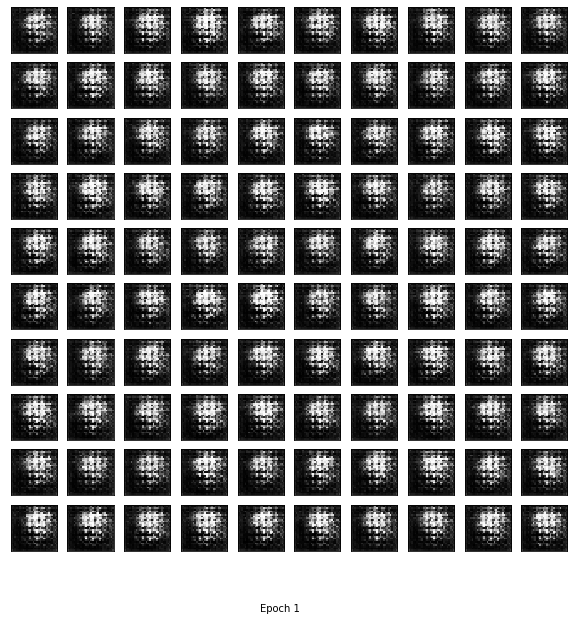

In [20]:
drop_percent_list = [0.975]
# drop_class = [[0], [1], [2], [0, 1, 2, 3, 4, 6, 7, 8, 9]]
drop_class_list = [[0, 1, 2, 3, 4, 6, 7, 8, 9]]
batch_size = 128
num_epochs = 10
for i in range(len(drop_percent_list)):
    for j in range(len(drop_class_list)):
        test_x, test_y = train_ACGAN(batch_size, num_epochs, drop_class_list[j], drop_percent_list[i])
        np.save(npys_dir + 'test_x' + '_' + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) + '.npy', test_x)
        np.save(npys_dir + 'test_y' + '_' + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) + '.npy', test_y)
        
        

In [ ]:
##### Make GIF #####
import imageio
for i in range(len(drop_percent_list)):
    for j in range(len(drop_class_list)):
        images = []
        for e in range(num_epochs - 1):
            img_name = path + 'Epoch:' + str(e + 1) + '_' + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) +'.png'
            images.append(imageio.imread(img_name))
        imageio.mimsave(path + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) + 'generation_animation.gif', images, fps=5)        
        
        

In [40]:
# tf.reset_default_graph()
# saver = tf.train.import_meta_graph('/home/cff/raghav/Restore/10_epoch_model__97.5.ckpt.meta')
# graph = tf.get_default_graph()
# for tensor in graph.get_operations():
#     print (tensor.name)

In [45]:
def retrain(batch_size, epochs, ckpt_path, drop_class_list, drop_percent):
    
    ckpt_epoch = int (ckpt_path.split('/')[5].split('_')[0])
    print ("Restoring training from epoch num: " + str(ckpt_epoch))
    tf.reset_default_graph() # Clears the tensorflow graph and resets it
    with tf.Session() as sess:
        # Restore model graph
        #Restores the graph stored in meta file
        saver = tf.train.import_meta_graph(ckpt_path + '.meta')
        graph = tf.get_default_graph() # This gets the graph
        
        #inputs
        x = graph.get_tensor_by_name('x:0')
        z = graph.get_tensor_by_name('z:0')
        y_label = graph.get_tensor_by_name('y_label:0')
        lr = graph.get_tensor_by_name('lr:0')
        dropout_rate = graph.get_tensor_by_name('dropout_rate:0')
        is_training = graph.get_tensor_by_name('is_training:0')
        global_step = graph.get_tensor_by_name('global_step:0')
        
        # Can build the graph again by initialising the variables (if same graph isn't made then weights won't get loaded correctly)
        
        # model = build_GAN(x, z, y_label, dropout_rate, is_training)
        # D_real_logits, Aux_real_logits, D_fake_logits, Aux_fake_logits, fake_images = model
        # D_loss, G_loss = loss_fnc(D_real_logits, D_fake_logits, Aux_real_logits, Aux_fake_logits, y_label)
        # D_opt, G_opt = optimizer(D_loss, G_loss, lr, global_step)
        # fixed_z, fixed_ylabel, y_ = fixed_test_input()
        
        #outputs
        D_loss = graph.get_tensor_by_name('D_loss_gan:0')
        G_loss = graph.get_tensor_by_name('G_loss_gan:0')
        fake_images = graph.get_tensor_by_name('fake_images_gan:0')
        D_opt = tf.get_collection("train_op_D")[0]
        G_opt = tf.get_collection("train_op_G")[0]
        # D_opt = graph.get_tensor_by_name('Optimiser/d_optimiser:0')
        # G_opt = graph.get_tensor_by_name('Optimiser/g_optimiser:0')
        print('Graph constructed')
        
        # Initialize all variables
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        print('Variables initialized')
        
        # Restore variables that were trained from previous session (a subset of all global & local variables)
        saver.restore(sess, ckpt_path)
        print("Trained Variables restored from previous session.")
        
        fixed_z, fixed_ylabel, y_ = fixed_test_input(num = 100)
        print ("\n Conditional input : ")
        print ("\n" + str(y_.reshape([10,10])))
        
        # Creating imbalanced dataset
        x_train, y_train, x_test, y_test, inverse_class_weights = get_imbalanced_train_data(drop_class_list, drop_percent)

        
#         #Make loaded predictions
#         print ("*********************** BACKCHODI SHURU***********************")
#         test_images = fake_images.eval(feed_dict = {z:fixed_z, y_label:fixed_ylabel, dropout_rate:0.6, is_training:False})
#         _x = x_train[0:128]
#         _y = y_train[0:128]
#         _y_label = onehot[_y.astype(np.int32)].reshape([128, 1, 1, num_classes])
#         _z = np.random.normal(0, 1, (128, 1, 1, 100))
#         train_feed_dict = {x:scale(_x), z:_z, y_label:_y_label, dropout_rate:0.6, is_training:False}
#         print ('D_loss: ' + str(D_loss.eval(feed_dict = train_feed_dict)))
#         print ('G_loss: ' + str(G_loss.eval(feed_dict = train_feed_dict)))
#         print ('lr: ' + str(lr.eval()))
#         show_result(rescale(test_images), num_epoch = 1, show = True, save = False)
#         print (test_images.shape)
#         print ("*********************** BACKCHODI KHATAM**********************")

        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['Epoch_time'] = []
        
        no_of_batches = int((x_train.shape[0]/batch_size))
        
        for epoch in range(ckpt_epoch, ckpt_epoch + epochs):
            
            epoch_start_time = time.time()
            train_D_losses = []
            train_G_losses = []
            
            print ('lr: ' + str(lr.eval()))
            for it in range(no_of_batches):
                
                batch_x = x_train[it*batch_size : (it+1)*batch_size]
                batch_y = y_train[it*batch_size : (it+1)*batch_size]
                
                _y_label = batch_y.reshape([batch_size, 1, 1, num_classes]) # 128*1*1*10 (One hot encoded 4-D)
                _z = np.random.normal(0, 1, (batch_size, 1, 1, 100))
                train_feed_dict = {x:scale(batch_x), z:_z, y_label:_y_label, dropout_rate:0.6, is_training:True}
                
                D_opt.run(feed_dict = train_feed_dict)
                G_opt.run(feed_dict = train_feed_dict)
                
                train_D_loss = D_loss.eval(feed_dict = train_feed_dict)
                train_G_loss = G_loss.eval(feed_dict = train_feed_dict)
                
                train_D_losses.append(train_D_loss)
                train_G_losses.append(train_G_loss)
                
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            print ('After epoch: '+ str(epoch+1) + ' Generator loss: ' + str(np.mean(train_G_losses)) + ' Discriminator loss: ' + str(np.mean(train_D_losses))
                   + ' Time taken for epoch: ' + str(epoch_time) + '\n')

            train_hist['D_losses'].append(np.mean(train_D_losses))
            train_hist['G_losses'].append(np.mean(train_G_losses))
            train_hist['Epoch_time'].append(epoch_time)
            
            test_images = fake_images.eval(feed_dict = {z:fixed_z, y_label:fixed_ylabel, dropout_rate:0.6, is_training:False})
            num_epoch = epoch+1
            fpath = path + 'Epoch:' + str(num_epoch) + '_' + str(drop_class_list) + '_' + str(drop_percent*100) +'.png'
            show_result(fpath, rescale(test_images), num_epoch, show = True, save = True)
            
#             name = str(epoch+1) + "_epoch_model_" + '_' + str(drop_class_list) + '_' + str(drop_percent*100) + ".ckpt"
            name = str(epoch+1) + "_epoch_model_" + '_' + str(drop_percent*100) + ".ckpt"        
            save_path = saver.save(sess, checkpoint_dir + name)
            print ("Saving session at path:" + save_path)
            
        samples_per_class = 100
        
        _z = np.random.normal(0, 1, (samples_per_class*num_classes, 1, 1, 100))
        ylabel = []
        for i in range(num_classes):
            for j in range(samples_per_class):
                ylabel.append(i * np.ones(shape = (1)))
        ylabel = np.asarray(ylabel)
        np.random.shuffle(ylabel)
        fixed_ylabel = onehot[ylabel.astype(np.int32)].reshape([samples_per_class*num_classes, 1, 1, num_classes])
        test_list = fake_images.eval(feed_dict = {z:_z, y_label:fixed_ylabel, dropout_rate:0.6, is_training:False})  
        test_list = rescale(test_list)
        
        print ("\n... Re-Training finish ...\n") 
        print (" Total time taken : " + str(np.sum(train_hist['Epoch_time'])))
        show_train_hist(train_hist, show = True, save = True)
        sess.close()
    return test_list, ylabel


Restoring training from epoch num: 10
Graph constructed
Variables initialized
Trained Variables restored from previous session.

 Conditional input : 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]
Per class count before dropping: 
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Per class count after dropping: 
[149, 169, 149, 154, 147, 5421, 148, 157, 147, 149]
lr: 0.00011974736
After epoch: 11 Generator loss: 0.7935895 Discriminator loss: 1.3969469 Time taken for epoch: 19.83503532409668

Figure saved for epoch: 11


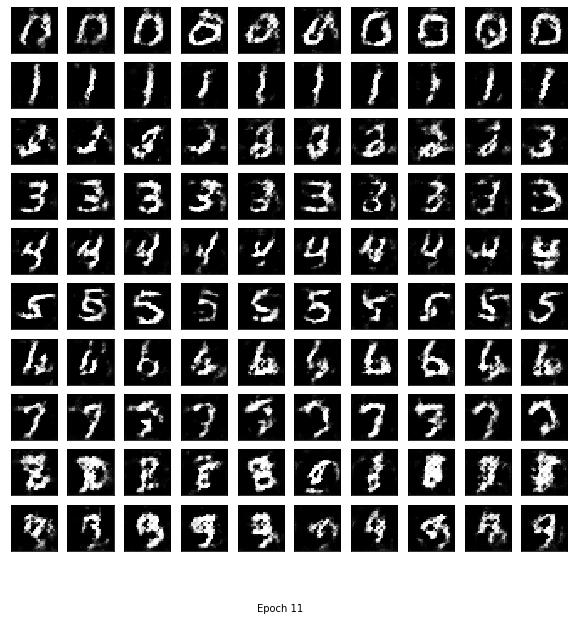

Saving session at path:/home/cff/raghav/Restore/11_epoch_model__97.5.ckpt
lr: 0.00011375999
After epoch: 12 Generator loss: 0.7872662 Discriminator loss: 1.3905723 Time taken for epoch: 17.544673681259155

Figure saved for epoch: 12


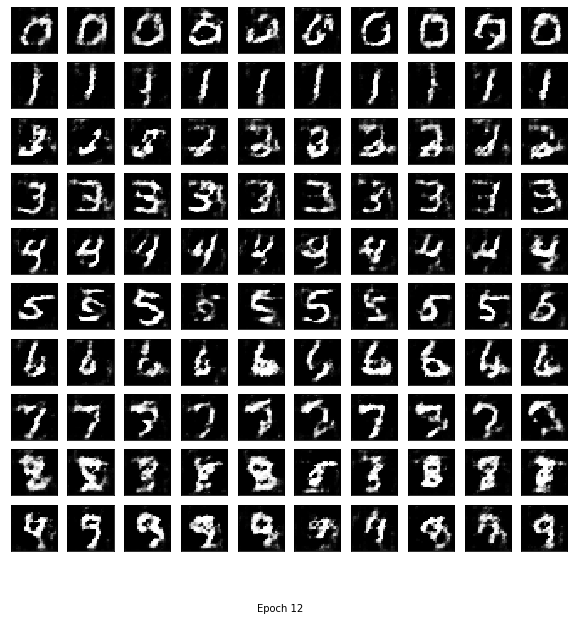

Saving session at path:/home/cff/raghav/Restore/12_epoch_model__97.5.ckpt
lr: 0.000108072
After epoch: 13 Generator loss: 0.79009986 Discriminator loss: 1.3877085 Time taken for epoch: 17.6313955783844

Figure saved for epoch: 13


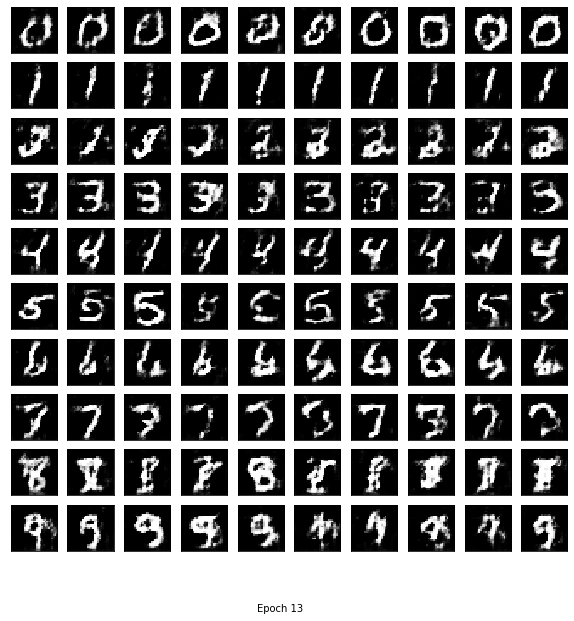

Saving session at path:/home/cff/raghav/Restore/13_epoch_model__97.5.ckpt
lr: 0.00010266839
After epoch: 14 Generator loss: 0.7864487 Discriminator loss: 1.3885676 Time taken for epoch: 17.507821321487427

Figure saved for epoch: 14


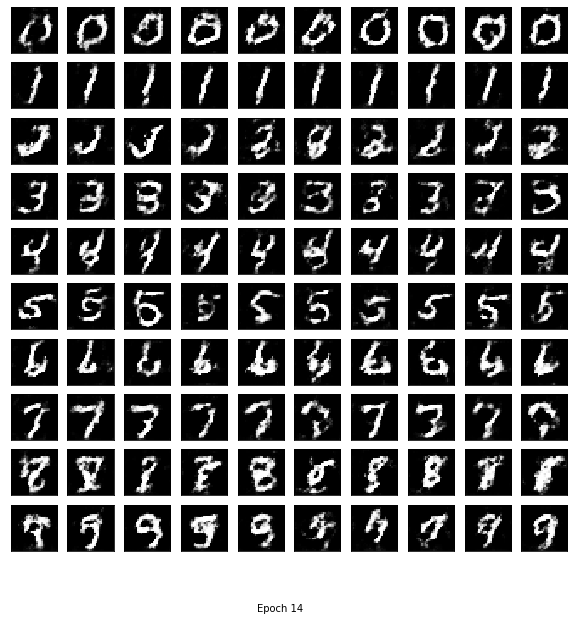

Saving session at path:/home/cff/raghav/Restore/14_epoch_model__97.5.ckpt
lr: 9.753498e-05
After epoch: 15 Generator loss: 0.78844583 Discriminator loss: 1.3824122 Time taken for epoch: 17.614717960357666

Figure saved for epoch: 15


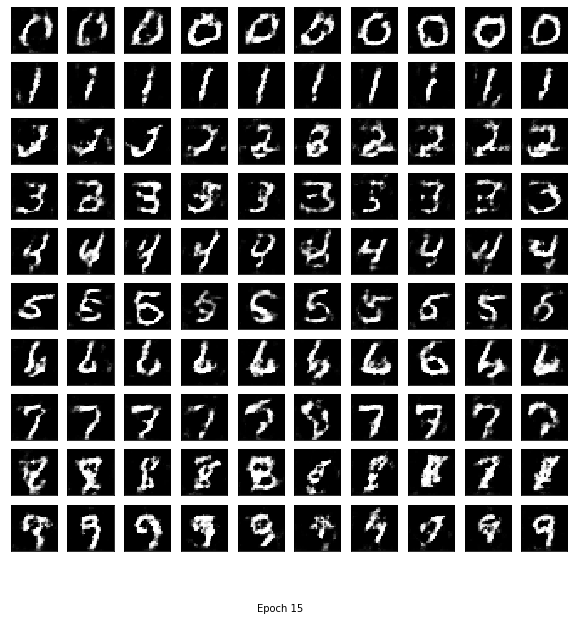

Saving session at path:/home/cff/raghav/Restore/15_epoch_model__97.5.ckpt
lr: 9.265823e-05
After epoch: 16 Generator loss: 0.788636 Discriminator loss: 1.3764043 Time taken for epoch: 17.520476579666138

Figure saved for epoch: 16


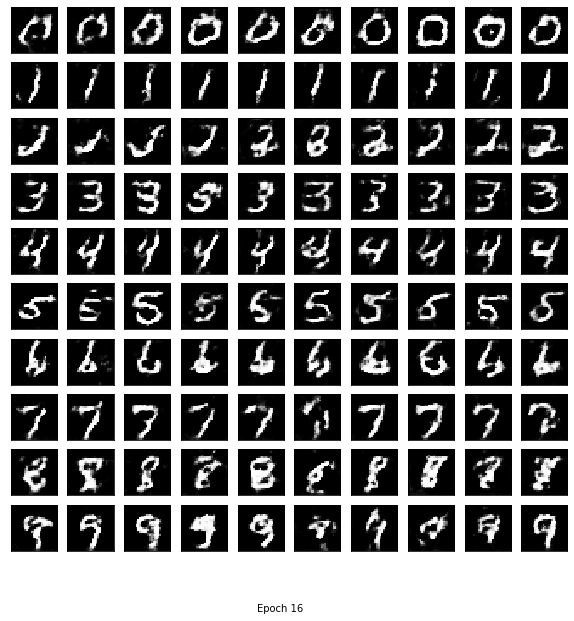

Saving session at path:/home/cff/raghav/Restore/16_epoch_model__97.5.ckpt
lr: 8.8025314e-05
After epoch: 17 Generator loss: 0.78922826 Discriminator loss: 1.372368 Time taken for epoch: 17.480275630950928

Figure saved for epoch: 17


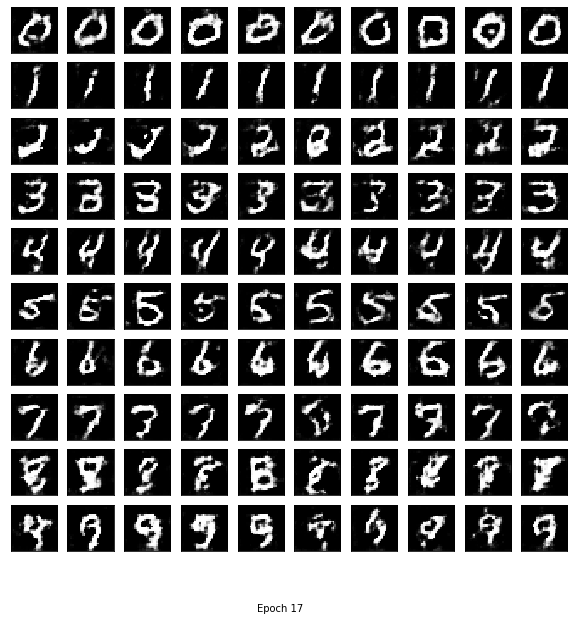

Saving session at path:/home/cff/raghav/Restore/17_epoch_model__97.5.ckpt
lr: 8.362404e-05
After epoch: 18 Generator loss: 0.7886802 Discriminator loss: 1.3757325 Time taken for epoch: 17.75400710105896

Figure saved for epoch: 18


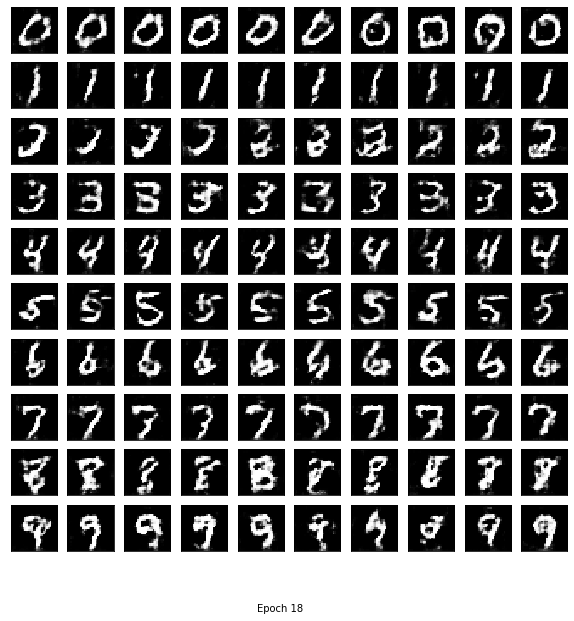

Saving session at path:/home/cff/raghav/Restore/18_epoch_model__97.5.ckpt
lr: 7.944284e-05
After epoch: 19 Generator loss: 0.7875947 Discriminator loss: 1.3692219 Time taken for epoch: 17.580026626586914

Figure saved for epoch: 19


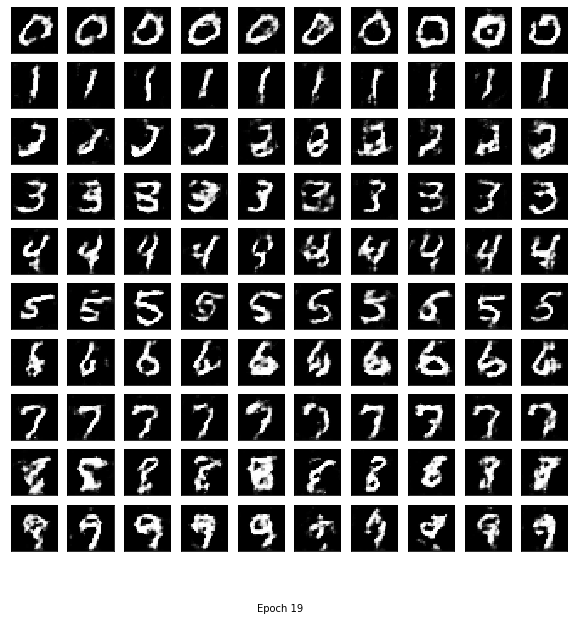

Saving session at path:/home/cff/raghav/Restore/19_epoch_model__97.5.ckpt
lr: 7.54707e-05
After epoch: 20 Generator loss: 0.7891322 Discriminator loss: 1.3759085 Time taken for epoch: 17.64642858505249

Figure saved for epoch: 20


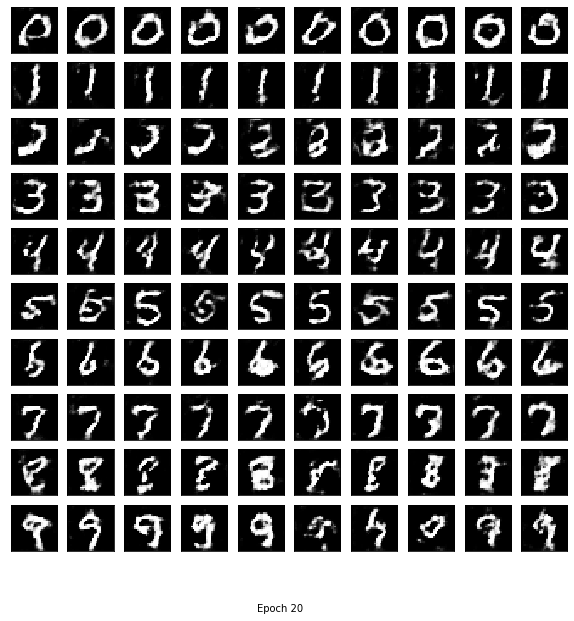

Saving session at path:/home/cff/raghav/Restore/20_epoch_model__97.5.ckpt

... Re-Training finish ...

 Total time taken : 178.11485838890076
Histogram saved


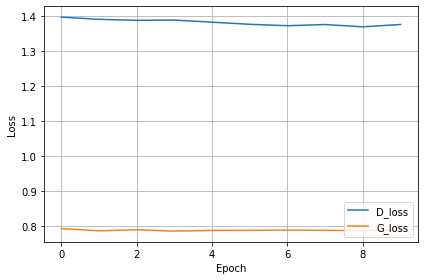

In [46]:
ckpt_path = '/home/cff/raghav/Restore/10_epoch_model__97.5.ckpt'
epochs = 10
# drop_percent_list = [0.975]
# # drop_class = [[0], [1], [2], [0, 1, 2, 3, 4, 6, 7, 8, 9]]
# drop_class_list = [[0, 1, 2, 3, 4, 6, 7, 8, 9]]
batch_size = 128
for i in range(len(drop_percent_list)):
    for j in range(len(drop_class_list)):
        test_x, test_y = retrain(batch_size, epochs, ckpt_path, drop_class_list[j], drop_percent_list[i])
        np.save(npys_dir + 'test_x' + '_' + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) + '.npy', test_x)
        np.save(npys_dir + 'test_y' + '_' + str(drop_class_list[j]) + '_' + str(drop_percent_list[i]*100) + '.npy', test_y)
        
        